In [152]:
import torch
from centralizado import load_model
from PIL import Image
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

import RouboProfundoGradiente as rpg

In [153]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CLASSES = ['aviao', 'carro', 'passaro', 'gato', 'veado', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhao']

In [175]:
# Função para carregar e processar uma única imagem
def process_image(image_path):
    image = Image.open(image_path).convert("RGB")
    
    # Aplicar transformações
    prep_transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Redimensionar para o tamanho esperado
        transforms.ToTensor(),
        transforms.CenterCrop(32),
        #transforms.Normalize(
        #    (0.5,0.5,0.5),  # img_mean
        #    (0.5,0.5,0.5)   # img_std
        #)
    ])
    
    image = prep_transform(image).unsqueeze(0)  # Adicionar dimensão do lote (batch dimension)
    
    return image

In [190]:
# Função para realizar a predição usando o modelo treinado
def predict_image(model, image_path):
    model.eval()

    input_image = process_image(image_path)
    input_image = input_image.to(DEVICE)
    
    # Fazer a predição
    with torch.no_grad():
        output = model(input_image)
    
    # Obter a classe prevista
    _, predicted_class = torch.max(output, 1)
    
    return predicted_class.item()

In [156]:
def predict_prob(model, image_path):
    model.eval()

    input_image = process_image(image_path)
    input_image = input_image.to(DEVICE)
    
    output = model(input_image)
    
    probs = torch.nn.functional.softmax(output, dim=1) * 100
    prob_dict = {}
    for i, classname in enumerate(CLASSES):
        prob = probs[0][i].item()
        print(f"{classname} probabilidade: {prob:.2f}")
        prob_dict[classname] = [prob]

In [157]:
# Função para carregar o modelo a partir de um arquivo
def load_model_from_file(file_path):
    modelo = load_model()  # Use a função adequada para criar o modelo inicial
    modelo.load_state_dict(torch.load(file_path))
    return modelo

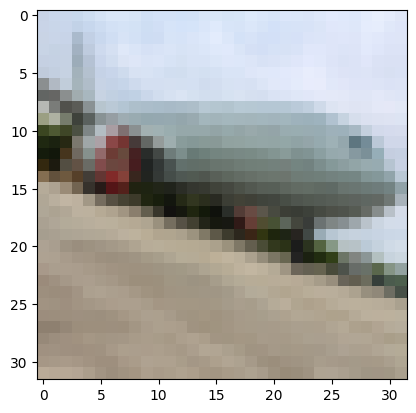

In [178]:
image = process_image("Imagens/aviao.jpg").to(DEVICE)
#image = transforms.ToPILImage()(image.squeeze(0))
plt.imshow(transforms.ToPILImage()(image.squeeze(0)))

In [180]:
sizeData = image.size()

torch.Size([1, 3, 32, 32])

In [185]:
modelo = load_model_from_file("modelo_treinado.pth")
predict_image(modelo, "Imagens/aviao.jpg")

'aviao'

In [193]:
gt_data = image.view(1, *image.size())
gt_label = torch.Tensor([predict_image(modelo, "Imagens/aviao.jpg")]).long().view(1, ).to(DEVICE)
gt_onehot_label = rpg.label_to_onehot(gt_label, 10).to(DEVICE)
gt_onehot_label

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [197]:
criterion = rpg.cross_entropy_for_onehot
out = modelo(image)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, modelo.parameters())
original_dy_dx = list((_.detach().clone() for _ in dy_dx))


In [209]:
import torch.nn.functional as F
history = []
tt = transforms.ToPILImage()

def deep_leakage_from_gradients(model, origin_grad, origin_data, origin_label): 
  dummy_data = torch.randn(origin_data.size()).requires_grad_(True).to(DEVICE)
  dummy_label =  torch.randn(origin_label.size()).requires_grad_(True).to(DEVICE)
  optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

  for iters in range(300):
    def closure():
      optimizer.zero_grad()
      dummy_pred = model(dummy_data) 
      dummy_loss = criterion(dummy_pred, F.softmax(dummy_label, dim=-1)) 
      dummy_grad = torch.autograd.grad(dummy_loss, model.parameters(), create_graph=True)

      grad_diff = 0
      for gx, gy in zip(dummy_grad, original_dy_dx): 
        grad_diff += ((gx - gy) ** 2).sum()
      
      print(grad_diff.item())
      
      grad_diff.backward()
      return grad_diff
    
    optimizer.step(closure)
    if iters % 10 == 0: 
      current_loss = closure()
      print(iters, "%.4f" % current_loss.item())
      history.append(tt(dummy_data[0].cpu()))
    
  #return  dummy_data, dummy_label

In [210]:

deep_leakage_from_gradients(modelo, original_dy_dx, image, gt_onehot_label)

4234.93115234375
4160.41455078125
3235.906494140625
2522.255615234375
2109.8974609375
1738.9986572265625
1643.4942626953125
1587.4989013671875
1472.82666015625
1595.8192138671875
1446.428466796875
1433.5948486328125
1412.2398681640625
1400.4779052734375
1391.5074462890625
1372.645263671875
1300.6162109375
3127318.75
1267.04833984375
1251.20849609375
1206.491455078125
0 1206.4915
1206.491455078125
1167.2735595703125
1097.96923828125
1032.955078125
1024.7510986328125
983.9510498046875
907.2957153320312
897.3385620117188
886.018798828125
869.7909545898438
858.1107177734375
875.9608764648438
784.6636962890625
769.19189453125
761.530029296875
751.31494140625
748.40185546875
745.3666381835938
741.8284301757812
739.2269287109375
734.7646484375
730.029541015625
728.7401123046875
716.990478515625
711.2778930664062
706.1651000976562
700.3106689453125
695.1790161132812
687.4566650390625
702.9635009765625
679.3831176757812
676.723876953125
673.516357421875
687.9157104492188
1519.1448974609375
681.